In [1]:
cd ~/projects/kinesis/

/Users/semyeong/projects/kinesis


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors, patches
import pandas as pd
import numpy as np
import palettable

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord

plt.rc("figure", dpi=120)
plt.rc('axes', labelsize=15)

In [3]:
import pystan

In [4]:
model = pystan.StanModel(file='isotropic_pm.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ff509558b522d9f94b377e1d8007223e NOW.
/Users/semyeong/miniconda3/envs/research/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/3b/xqmvtk4n1gz65l3889yqq_840000gn/T/tmpuwliod6o/stanfit4anon_model_ff509558b522d9f94b377e1d8007223e_2088739647515858925.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [60]:
# cl_xyz, cl_vxyz = [17.7, 41.2, 13.3]*u.pc, [-6.32, 45.24, 5.30]*u.km/u.s
# cl_xyz, cl_vxyz = [17.7, 41.2, 13.3]*u.pc, [-21., 5., 8.2]*u.km/u.s
cl_xyz, cl_vxyz = [-13.0, 50.1, 10.3]*u.pc, [-16.32, 45.24, 5.30]*u.km/u.s
cl_xyz, cl_vxyz = [-13.0, 50.1, 10.3]*u.pc, [-6.32, 5.24, 0.30]*u.km/u.s
N = 100
mem_xyz = np.random.normal(cl_xyz, 10, size=(N,3)) * u.pc
mem_vxyz = np.repeat(cl_vxyz[None,:].value, N, axis=0) * u.km/u.s\
    +np.random.normal(0, .1, size=(N,3))*u.km/u.s

mem_coords = coord.ICRS(*mem_xyz.T, v_x=mem_vxyz[:,0], v_y=mem_vxyz[:,1], v_z=mem_vxyz[:,2],
                        representation_type='cartesian', differential_type='cartesian')

In [61]:
mem_coords_spherical = mem_coords.spherical

ra, dec = mem_coords.represent_as('spherical').lon.deg, mem_coords.represent_as('spherical').lat.deg
pmra = mem_coords_spherical.differentials['s'].d_lon.to(u.mas/u.yr).value
pmdec = mem_coords_spherical.differentials['s'].d_lat.to(u.mas/u.yr).value
parallax = 1e3/mem_coords_spherical.distance.pc

In [66]:
a0 = np.vstack([parallax, pmra, pmdec]).T
C = np.repeat(np.diag([0.727**2, 0.1722**2, 0.973**2])[None,:], N, axis=0)*100
print(a0.shape, C.shape)
# jitter by observation noise
a = np.vstack(list(map(lambda x, y: np.random.multivariate_normal(x, y), a0, C)))

(100, 3) (100, 3, 3)


```
ra_error                            0.0726206
dec_error                            0.031773
parallax_error                      0.0726923
parallax_over_error                   287.579
pmra_error                           0.172283
pmdec_error                         0.0973153
astrometric_pseudo_colour_error    0.00876806
```

In [67]:
data = dict(ra=ra, dec=dec, a=a, C=C, N=N)
init = lambda: dict(d=mem_coords_spherical.distance.pc,
                    v0=[30,20,10],
                    sigv=0.1)
r = model.optimizing(data=data, init=init, verbose=True, )

In [71]:
u.deg.to(u.mas) / 1e6

3.5999999999999996

In [68]:
cl_vxyz

<Quantity [-6.32,  5.24,  0.3 ] km / s>

In [69]:
r['v0'], r['sigv']

(array([-6.82115398,  5.51054711,  0.28244503]), array(0.00135814))

In [10]:
from corner import corner

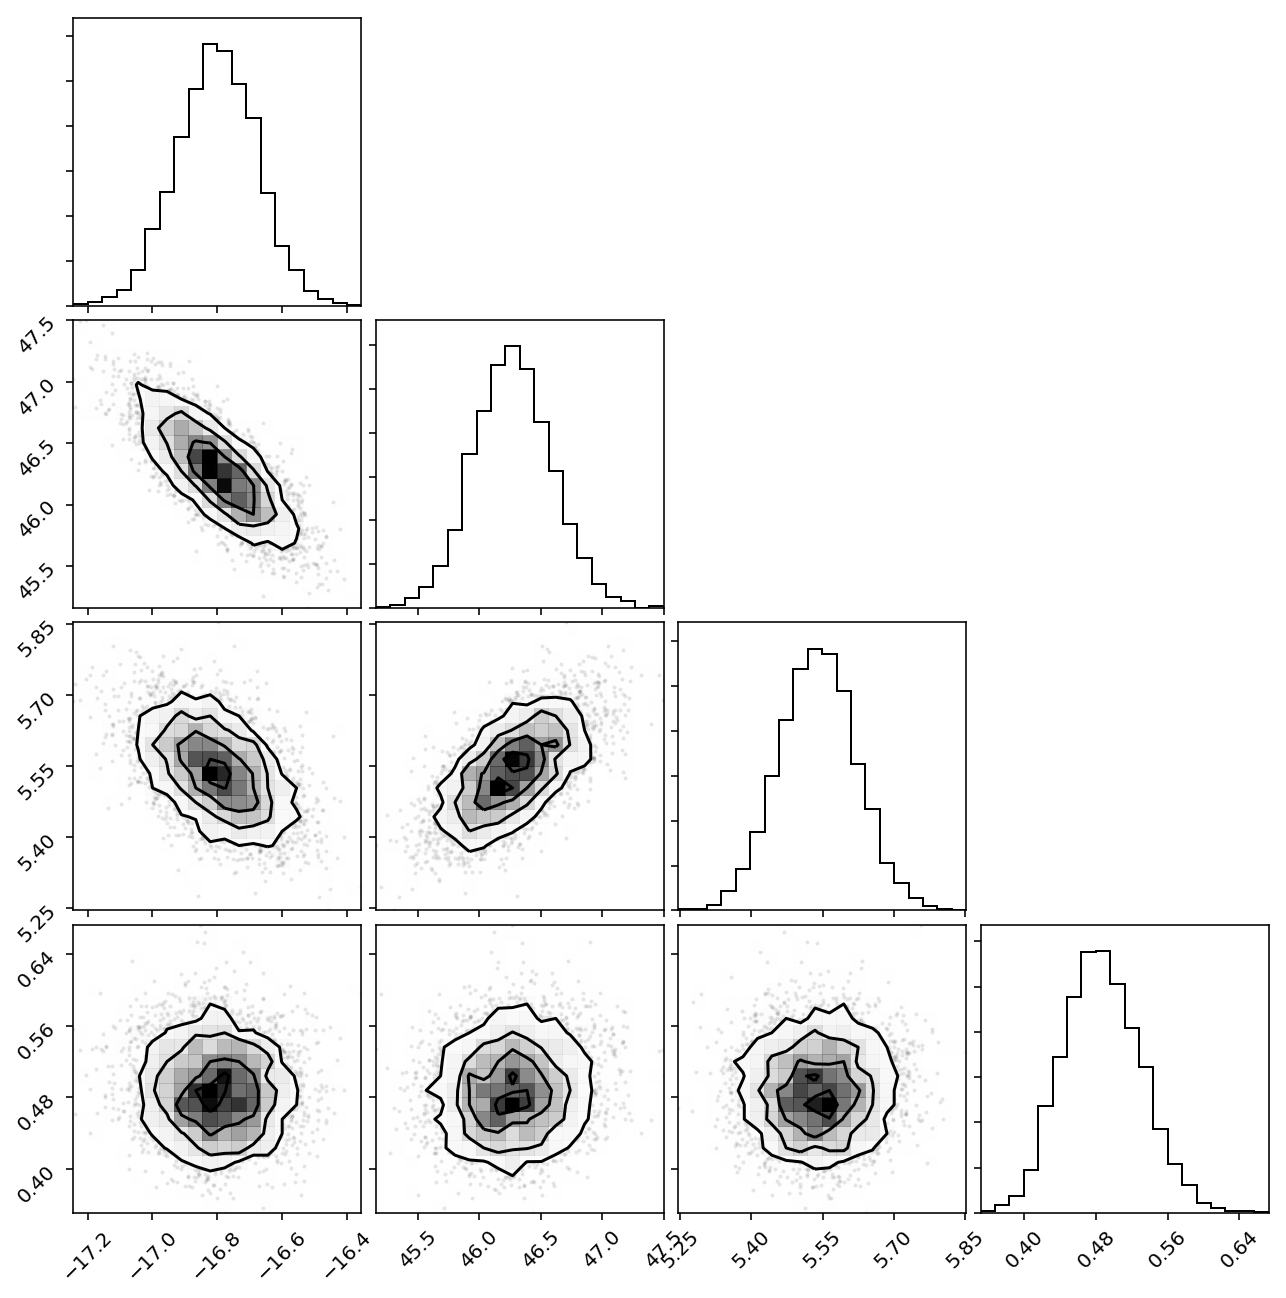

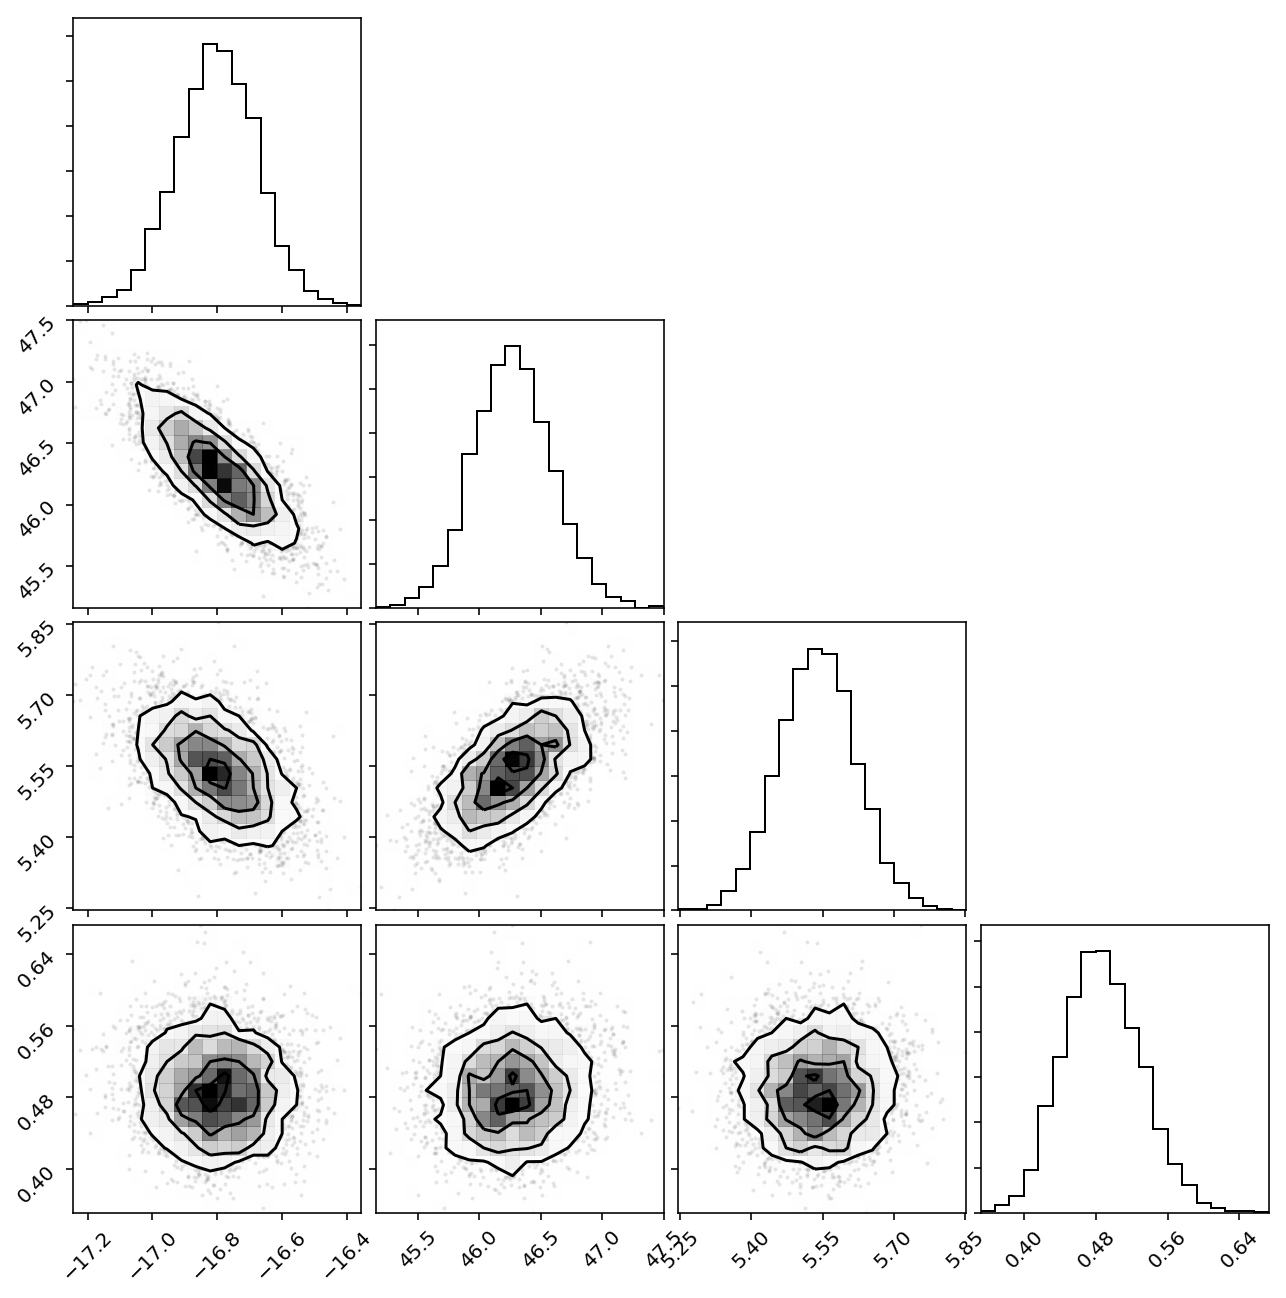

In [13]:
corner(np.hstack([r['v0'], r['sigv'][:,None]]))

In [3]:
d1 = pd.read_csv("../data/oh17/oh17star_dr1_tgas.csv")
d2 = pd.read_csv("../data/oh17/oh17star_dr2.csv")

# Clean object columns
d1['name'] = d1.name.str[2:-1]
d1['tycho2_id'] = d1.tycho2_id.str[2:-1]

d2['name'] = d2.name.str[2:-1]
d2['designation'] = d2['designation'].str[2:-1]
d2['phot_variable_flag'] = d2['phot_variable_flag'].str[2:-1]

In [4]:
len(d1), len(d2)

(10606, 10606)

Examine entries missing in DR2.

In [5]:
n_missing = len(d2) - d2.designation.value_counts().value_counts().loc[1]
print("# of missing sources in DR2 = {:d}".format(n_missing))

# of missing sources in DR2 = 1715


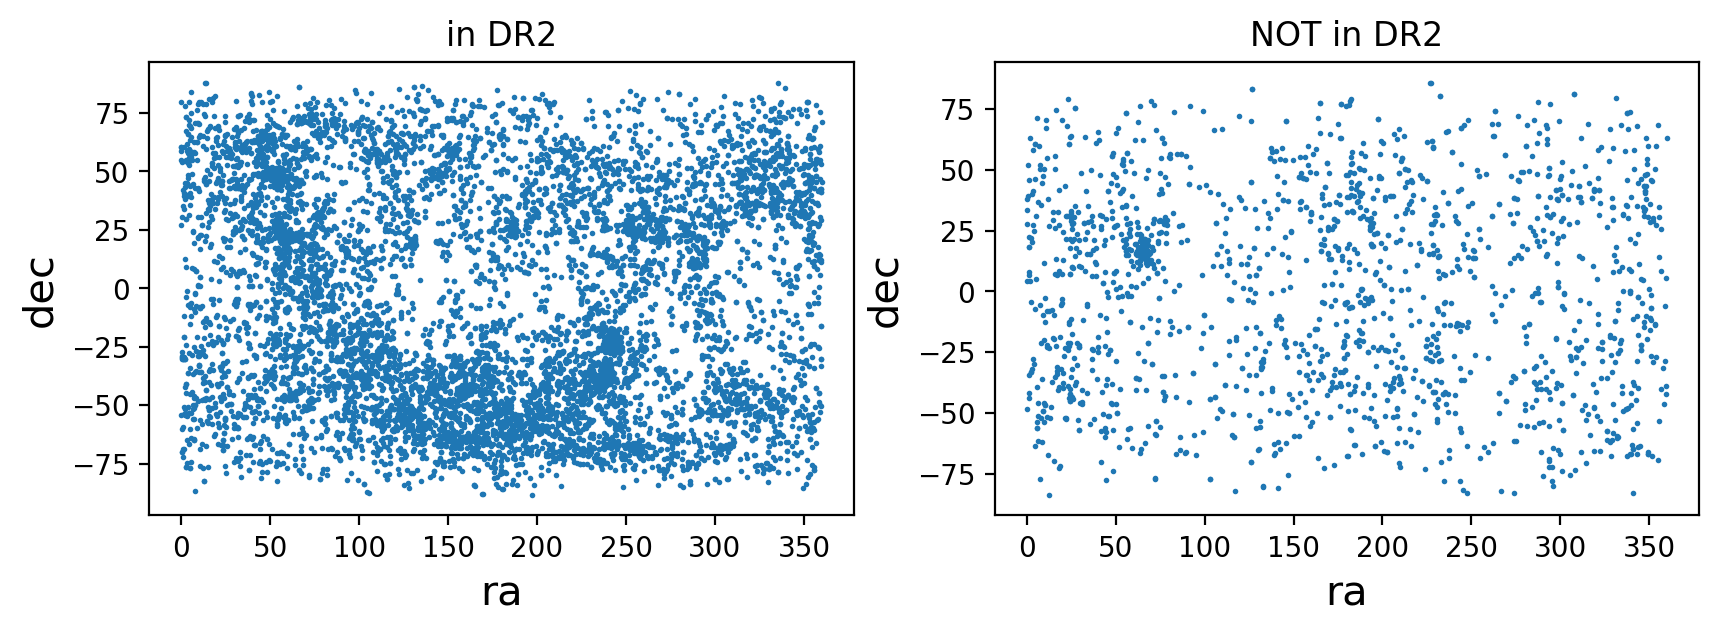

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
d1.loc[d2.source_id.notnull()].plot.scatter('ra','dec',s=1, ax=ax[0])
d1.loc[d2.source_id.isnull()].plot.scatter('ra','dec',s=1, ax=ax[1]);
ax[0].set_title('in DR2')
ax[1].set_title('NOT in DR2');

In [7]:
grp = d2.groupby('group_id')

In [8]:
grp.source_id.agg(lambda x: x.isnull().sum()).sort_values(ascending=False).head()

group_id
2     92.0
15     7.0
50     5.0
64     4.0
96     4.0
Name: source_id, dtype: float64

In [9]:
grp.size().loc[2]

118

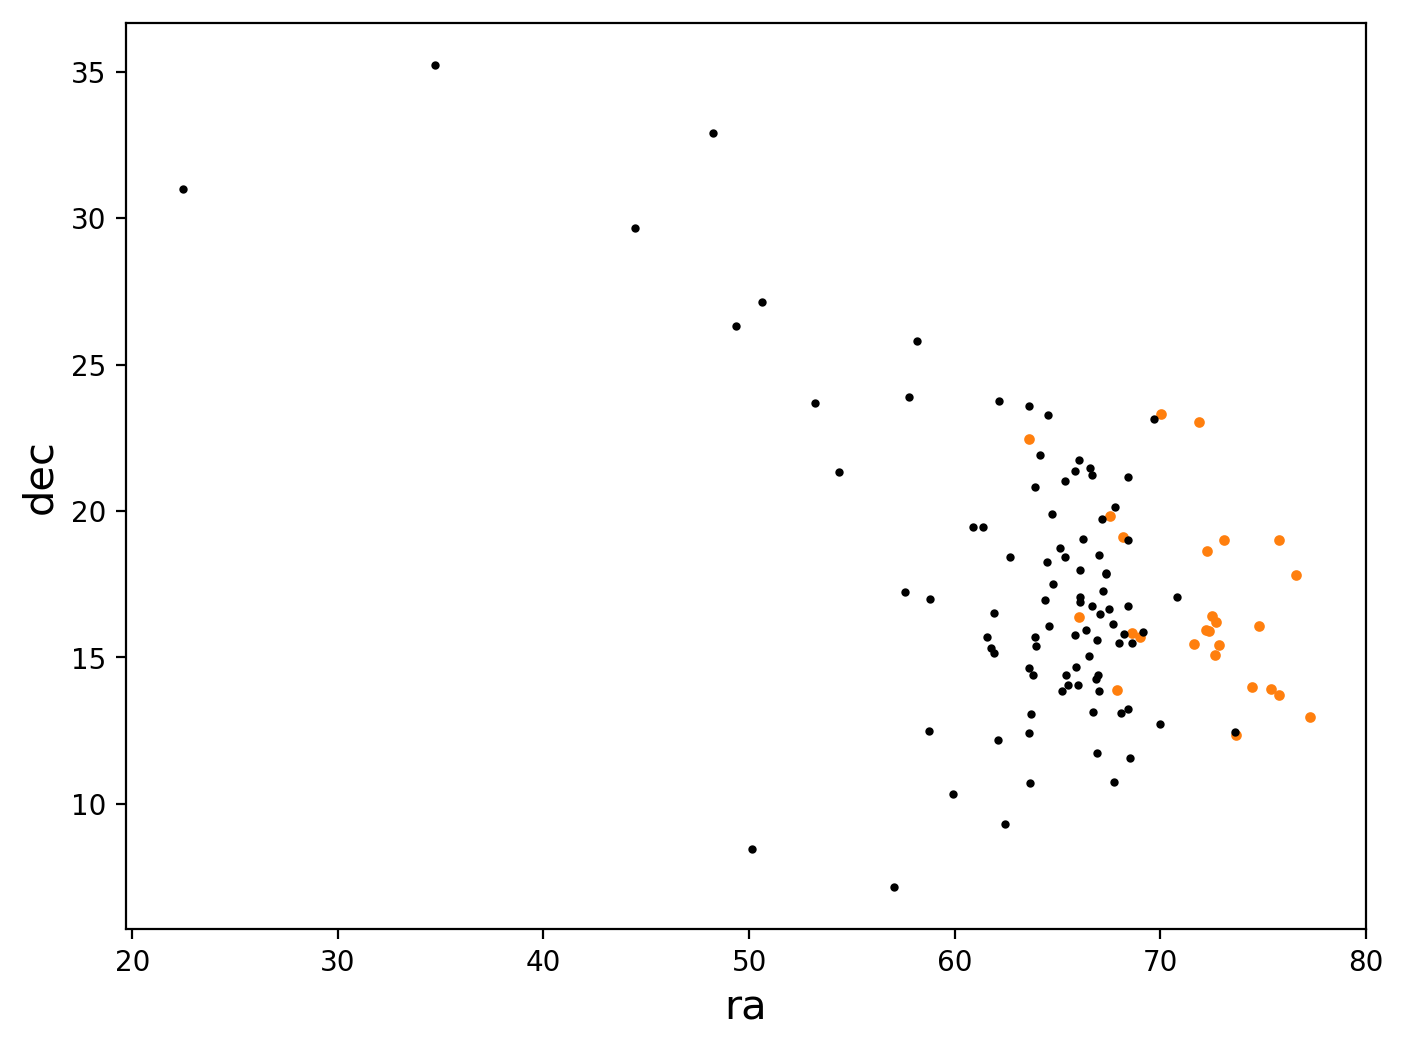

In [10]:
plt.figure(figsize=(8,6))
g2_dr1 = d1.groupby('group_id').get_group(2)
g2_dr2 = d2.groupby('group_id').get_group(2)

g2_dr1.loc[g2_dr2.source_id.notnull()].plot.scatter('ra','dec',s=8, c='tab:orange', ax=plt.gca());
g2_dr1.loc[g2_dr2.source_id.isnull()].plot.scatter('ra','dec',s=4, ax=plt.gca(), c='k');

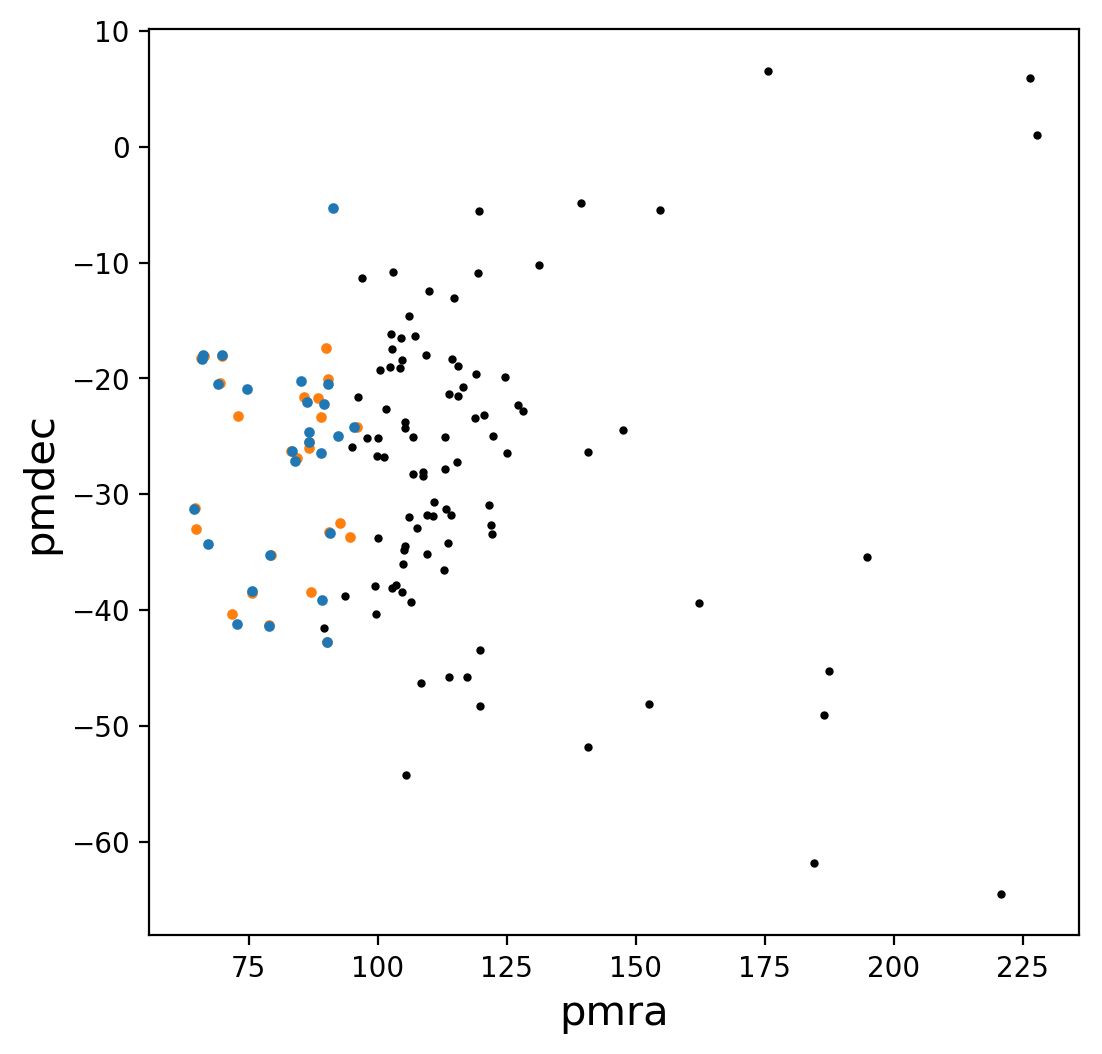

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

g2_dr1.loc[g2_dr2.source_id.notnull()].plot.scatter('pmra','pmdec',s=8, c='tab:orange', ax=ax);
g2_dr1.loc[g2_dr2.source_id.isnull()].plot.scatter('pmra','pmdec',s=4, ax=ax, c='k');

g2_dr2.loc[g2_dr2.source_id.notnull()].plot.scatter('pmra','pmdec',s=8, c='tab:blue', ax=ax);


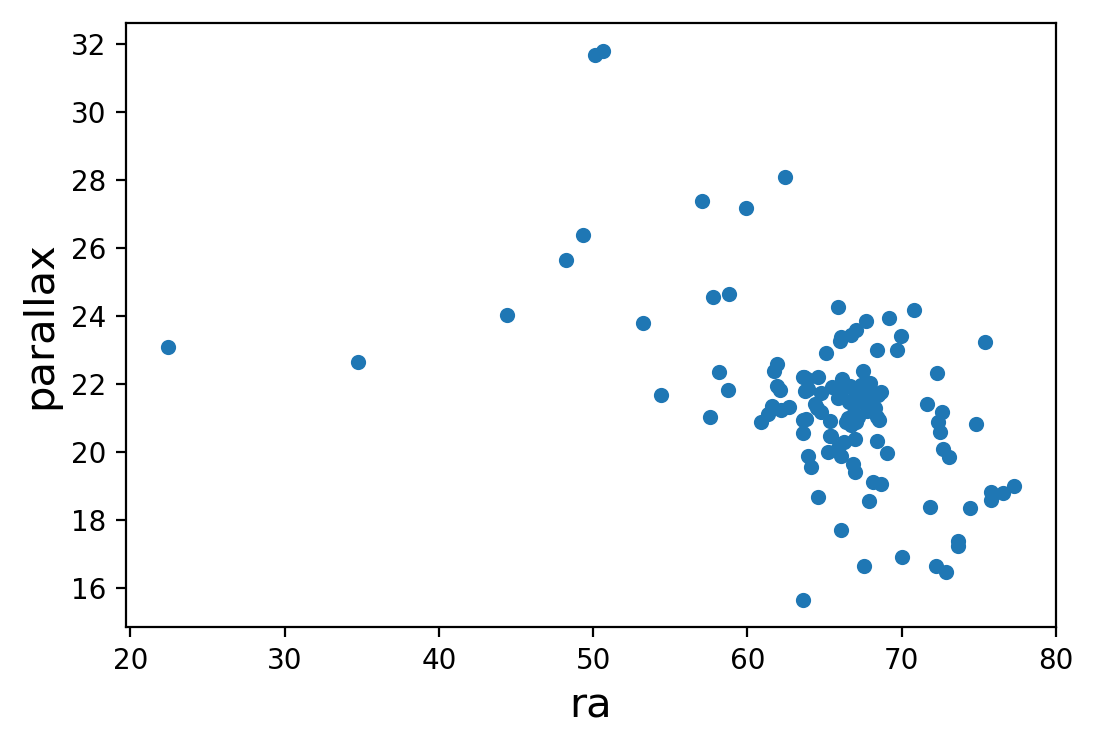

In [12]:
g2_dr1.groupby('group_id').get_group(2).plot.scatter('ra', 'parallax');

In [13]:
g2_dr1['hip'].loc[g2_dr2.source_id.isnull()].notnull().value_counts()

True     79
False    13
Name: hip, dtype: int64

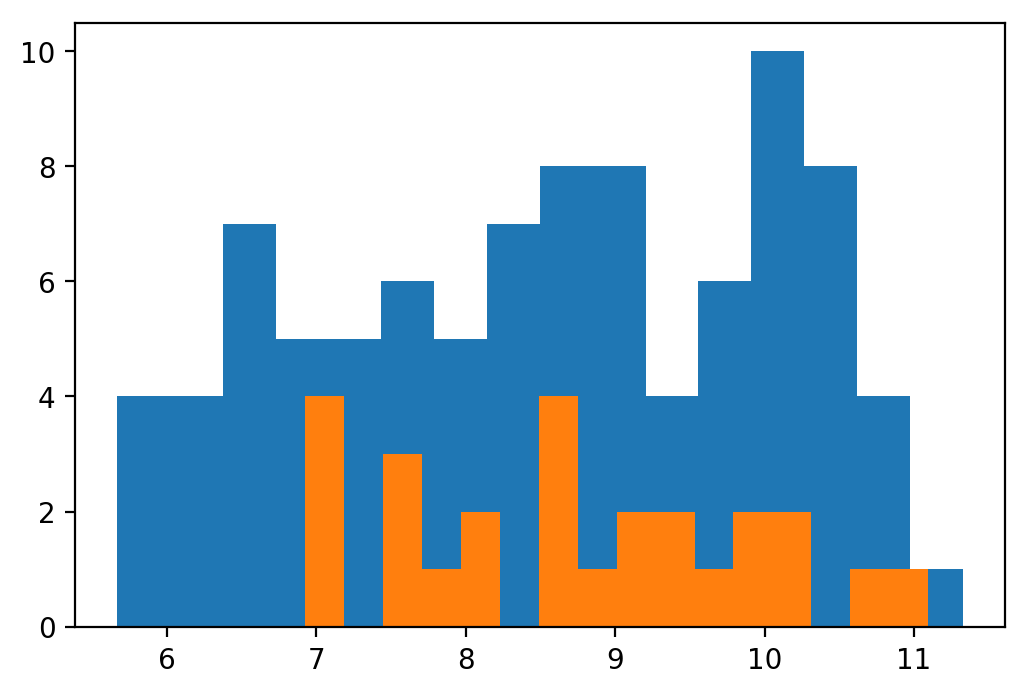

In [14]:
plt.hist(g2_dr1.loc[g2_dr2.source_id.isnull(), 'phot_g_mean_mag'], 16)
plt.hist(g2_dr1.loc[g2_dr2.source_id.notnull(), 'phot_g_mean_mag'], 16);

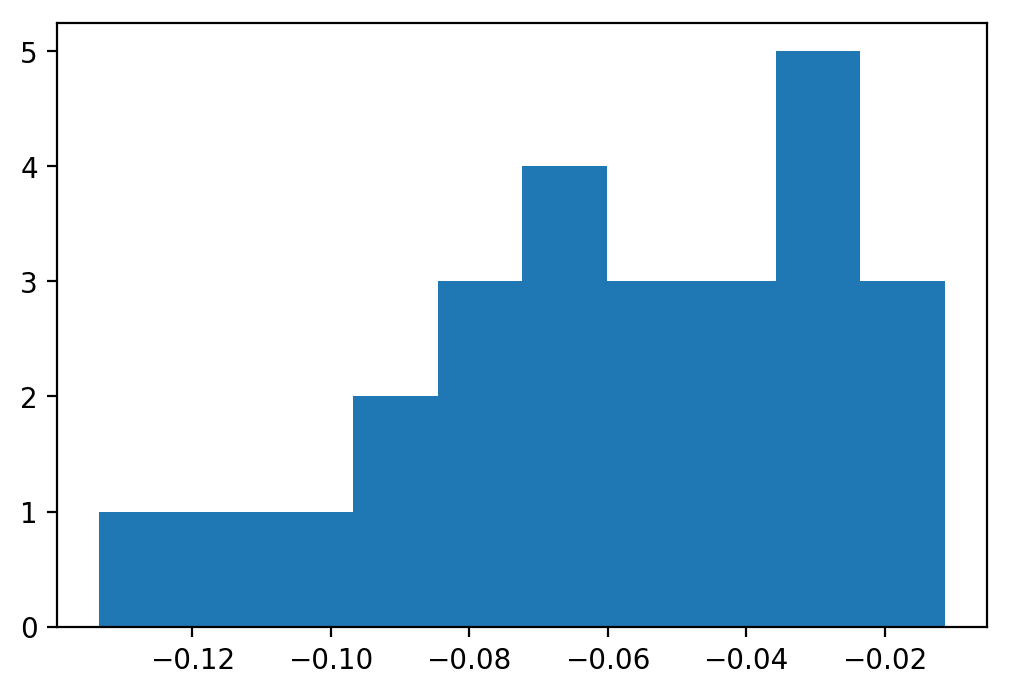

In [15]:
plt.hist(g2_dr1.loc[g2_dr2.source_id.notnull(), 'phot_g_mean_mag']-
         g2_dr2.loc[g2_dr2.source_id.notnull(), 'phot_g_mean_mag']);

In [50]:
vL_table = Table.read("../data/gaia-dr2-clusters/tablea1a.dat", format='ascii.cds',
                readme='../data/gaia-dr2-clusters/ReadMe')
vL = vL_table.to_pandas()

In [52]:
query_match_newhip = """
select *
from TAP_UPLOAD.hy left join gaiadr2.gaia_source
  on TAP_UPLOAD.hy.Source = gaiadr2.gaia_source.source_id"""

vL_hyades_full = Gaia.launch_job(query_match_newhip, upload_resource=vL_table[vL_table['Cluster'] == 'Hyades'], upload_table_name='hy').get_results()

In [54]:
len(vL_hyades_full), np.sum(vL_table['Cluster'] == 'Hyades')

(515, 515)

In [17]:
hyades = vL.groupby('Cluster').get_group('Hyades')

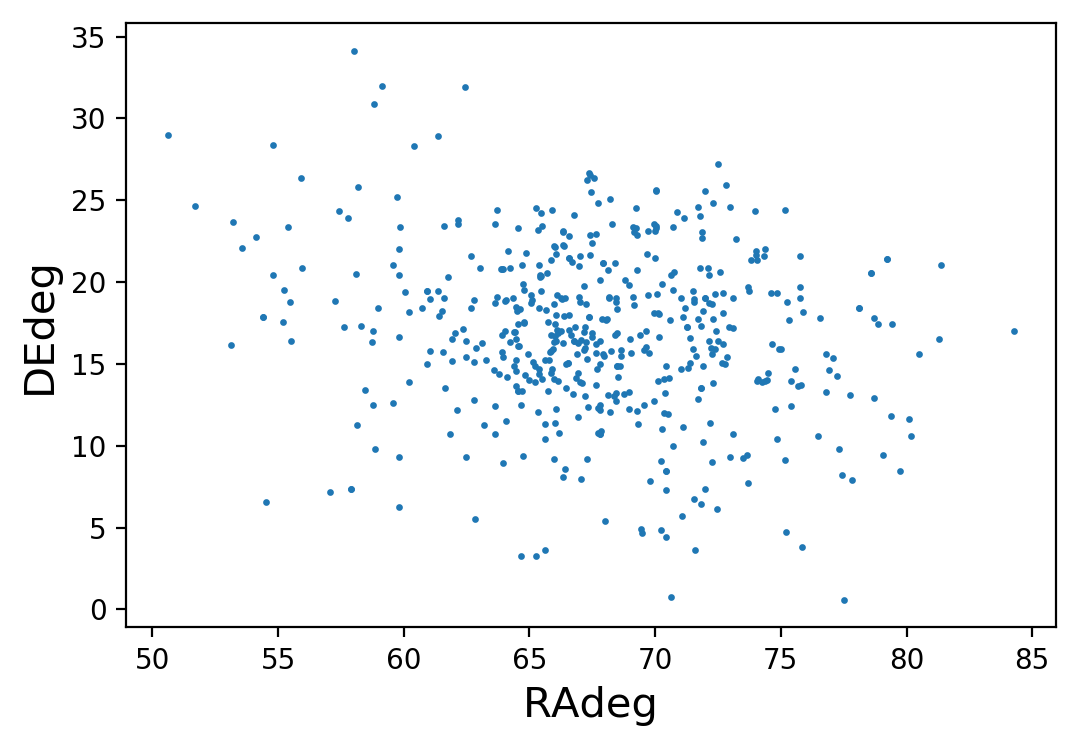

In [18]:
hyades.plot.scatter('RAdeg', 'DEdeg', s=2);

In [21]:
hyades_hip = Table.read("../data/hipparcos-hyades/table2.dat", format='ascii.cds',
                        readme='../data/hipparcos-hyades/ReadMe')

In [22]:
hyades_hip[:3]

HIP,vB,n_vB,MembvB,vA,n_vA,MembvA,Han,n_Han,MembHan,Pel,n_Pel,MembPel,Grif,n_Grif,MembGrif,Scha,n_Scha,MembScha,plx,e_plx,RV,u_RV,n_RV,e_RV,r_RV,Note,Note2,Note3,Dist,Stat,Memb
,,,,,,,,,,,,,,,,,,,mas,mas,km / s,,,km / s,,,,,pc,,
int64,int64,str1,int64,int64,str1,int64,int64,str1,int64,int64,str1,int64,int64,str1,int64,int64,str1,int64,float64,float64,float64,str1,str1,float64,int64,str2,str1,str3,float64,float64,str1
10540,157,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,24.93,0.88,26.0,--,--,1.2,2,--,--,--,24.6,43.09,0
10672,--,n,--,--,n,--,--,n,--,--,n,--,--,n,--,--,n,--,15.37,1.29,26.4,--,--,0.32,24,--,--,--,37.1,9.81,1
12031,--,n,--,--,n,--,--,n,--,--,n,--,--,n,--,--,n,--,13.44,3.62,--,--,--,--,0,--,--,--,41.8,1.11,?


In [20]:
from astroquery.gaia import Gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [25]:
query_match_newhip = """
select *
from TAP_UPLOAD.hy left join public.hipparcos_newreduction newhip
  on TAP_UPLOAD.hy.HIP = newhip.hip"""

r = Gaia.launch_job(query_match_newhip, upload_resource=hyades_hip, upload_table_name='hy').get_results()

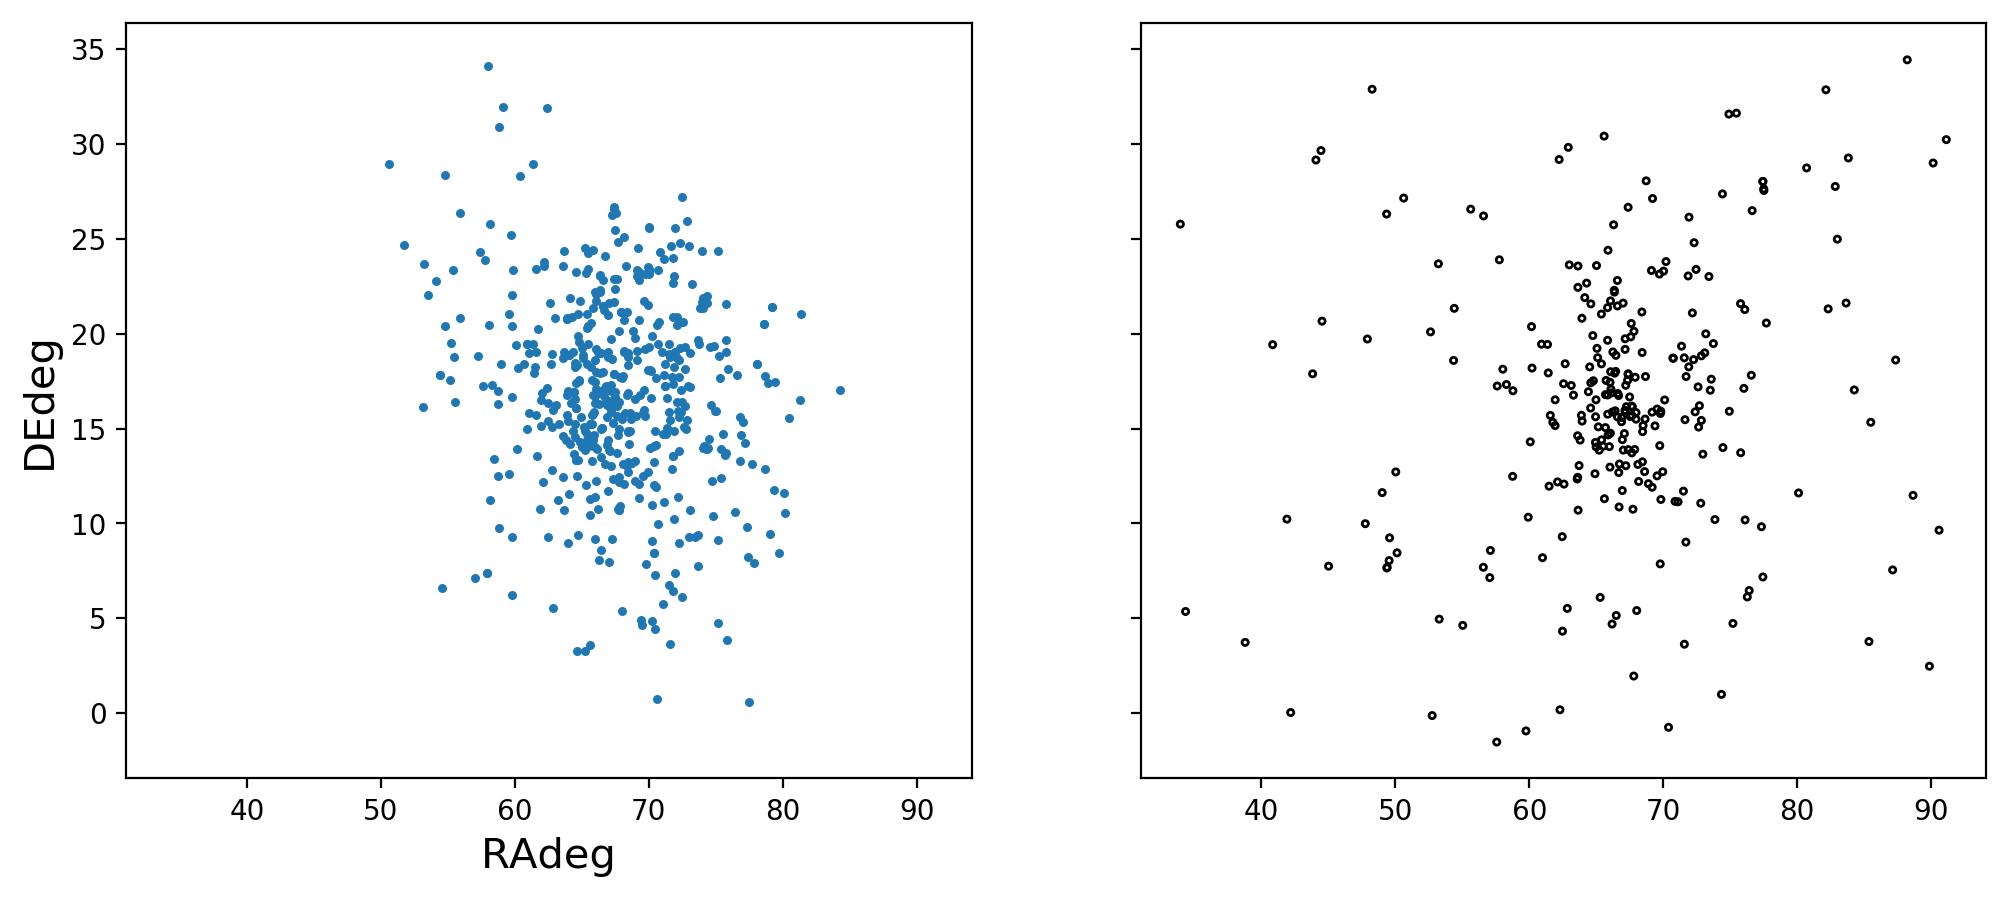

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
hyades.plot.scatter('RAdeg', 'DEdeg', s=5, ax=ax[0]);
ax[1].scatter(r['ra'], r['dec'], s=5, edgecolors='k', facecolors='None');

In [3]:
test_table = Table(data={'a':[1,2,3,4,5], 'b':[6,7,8,9,10]})
Gaia.launch_job("select * from TAP_UPLOAD.t1", upload_resource=test_table, upload_table_name='t1')

In [6]:
_3.get_results()

a,b
int64,int64
1,6
2,7
3,8
4,9
5,10


In [4]:
test_table.write('test.xml', format='votable')

In [5]:
with open('test.xml', 'r') as f:
    dd=f.read()

In [7]:
type(dd)

str

In [16]:
from io import BytesIO, StringIO

f = BytesIO()
test_table.write(f, format='votable')

In [17]:
f.seek(0)

0

In [18]:
f.read().decode()

'<?xml version="1.0" encoding="utf-8"?>\n<!-- Produced with astropy.io.votable version 3.0.4\n     http://www.astropy.org/ -->\n<VOTABLE version="1.3" xmlns="http://www.ivoa.net/xml/VOTable/v1.3" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.3">\n <RESOURCE type="results">\n  <TABLE>\n   <FIELD ID="a" datatype="long" name="a"/>\n   <FIELD ID="b" datatype="long" name="b"/>\n   <DATA>\n    <TABLEDATA>\n     <TR>\n      <TD>1</TD>\n      <TD>6</TD>\n     </TR>\n     <TR>\n      <TD>2</TD>\n      <TD>7</TD>\n     </TR>\n     <TR>\n      <TD>3</TD>\n      <TD>8</TD>\n     </TR>\n     <TR>\n      <TD>4</TD>\n      <TD>9</TD>\n     </TR>\n     <TR>\n      <TD>5</TD>\n      <TD>10</TD>\n     </TR>\n    </TABLEDATA>\n   </DATA>\n  </TABLE>\n </RESOURCE>\n</VOTABLE>\n'

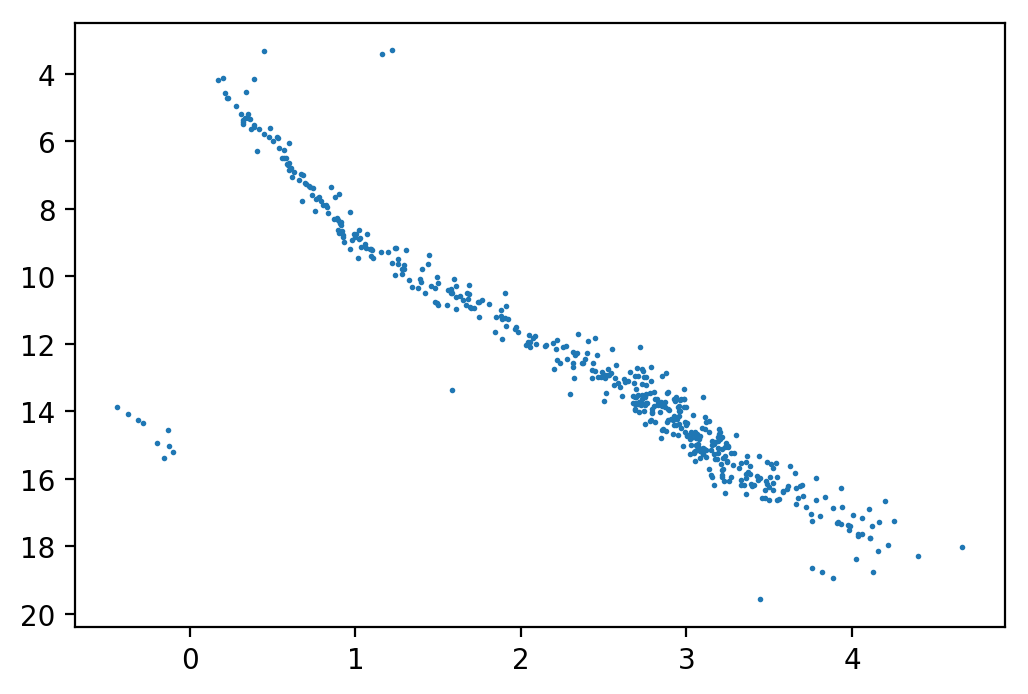

In [58]:
plt.scatter(vL_hyades_full['bp_rp'], vL_hyades_full['phot_g_mean_mag'], s=1);
plt.gca().invert_yaxis();

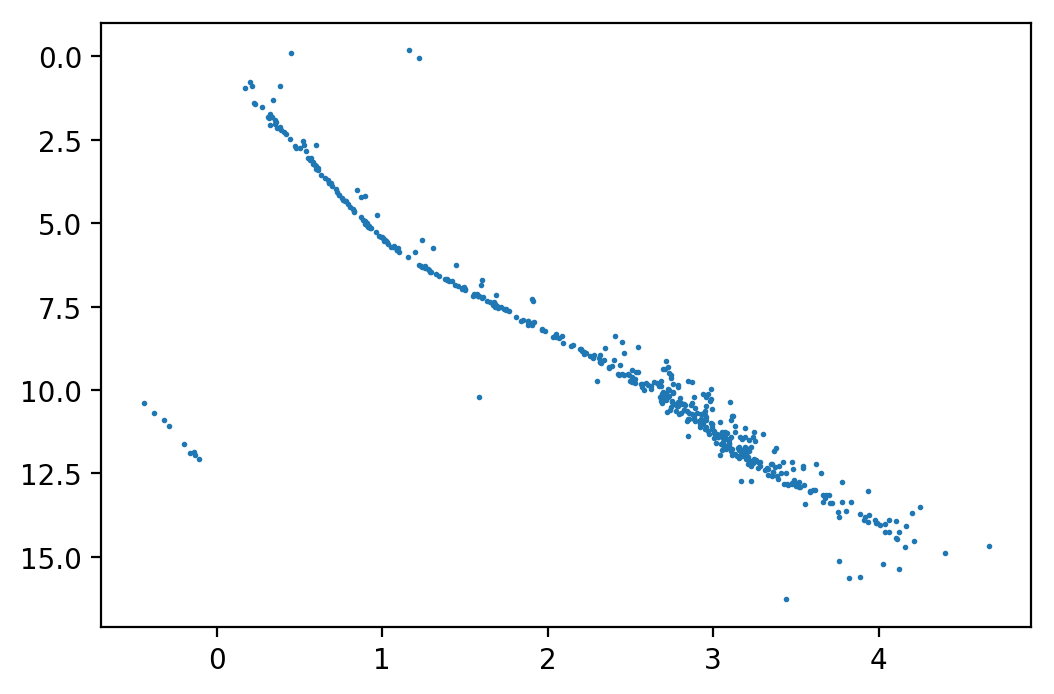

In [60]:
plt.scatter(vL_hyades_full['bp_rp'], vL_hyades_full['phot_g_mean_mag']+5*np.log10(vL_hyades_full['parallax'])-10, s=1);
plt.gca().invert_yaxis();

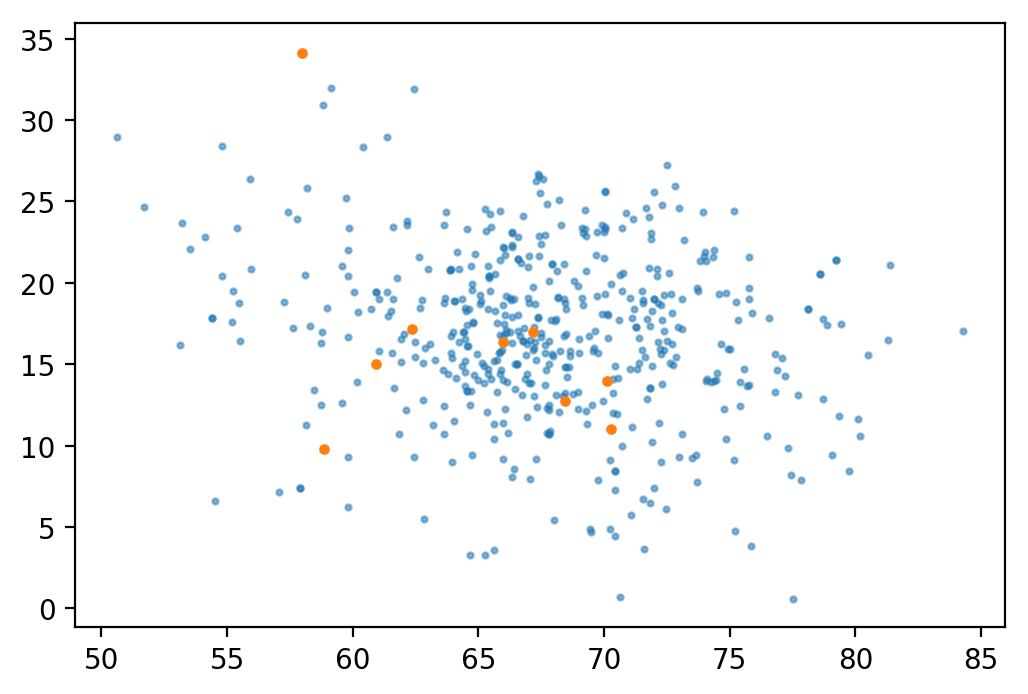

In [68]:
wd = (vL_hyades_full['bp_rp']<0) & (vL_hyades_full['phot_g_mean_mag']>12)

plt.scatter(vL_hyades_full['ra'], vL_hyades_full['dec'], s=4, alpha=0.5)
plt.scatter(vL_hyades_full['ra'][wd], vL_hyades_full['dec'][wd], s=8);

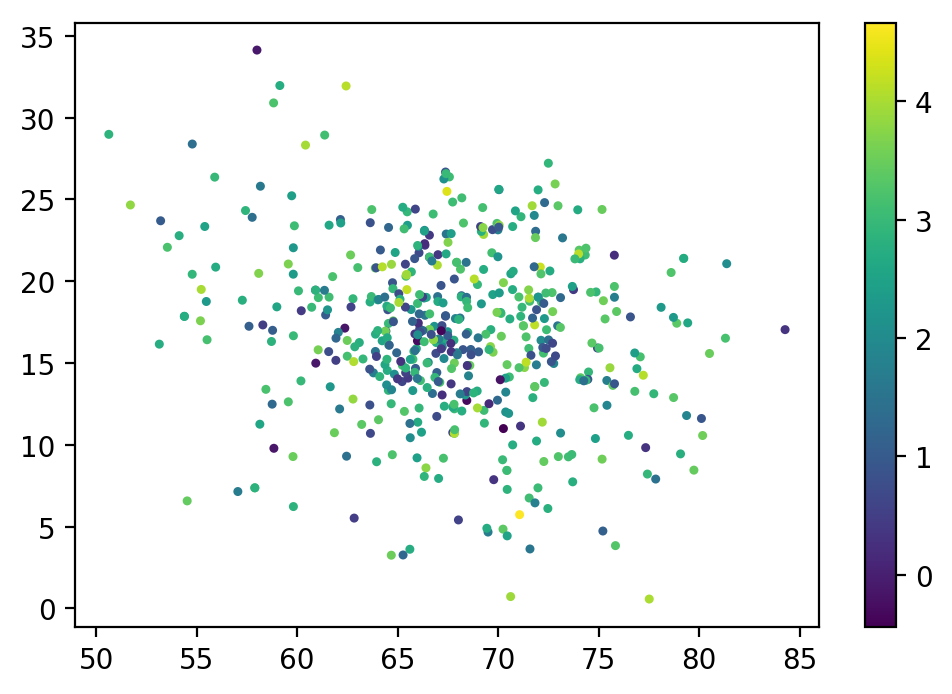

In [71]:
plt.scatter(vL_hyades_full['ra'], vL_hyades_full['dec'], c=vL_hyades_full['bp_rp'], s=5);
plt.colorbar();